# Safety Adherence Benchmark - Core Analysis

This notebook generates visualizations to answer our core research questions:

- **RQ1**: Principle Influence & Prioritization
- **RQ2**: Compliant Solution Finding & Efficiency Cost
- **RQ3**: Model Variation in Principle Adherence
- **RQ4**: Impact of Principle Type

Our goal is to explore how language models balance task completion with safety principles.

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set style parameters
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

# Configure paths
data_path = os.path.join('..', 'src', 'benchmark_results_all.csv')
output_dir = os.path.join('..', 'results', 'core_plots')
os.makedirs(output_dir, exist_ok=True)

# Helper function to ensure percentages are displayed correctly
def format_percent_axis(ax):
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_yticklabels([f'{int(x*100)}%' for x in ax.get_yticks()])

In [3]:
# Load and prepare the data
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} rows of data")

# Create scenario classification
conflict_avoidable = {
    'P1': ['P1-S1', 'P1-S2'],
    'P2': ['P2-S2', 'P2-S3'],
    'P3': ['P3-S2', 'P3-S4']
}

# Add conflict type column to the dataframe
df['conflict_type'] = df.apply(
    lambda row: 'Conflict-Avoidable' if row['scenario_id'] in conflict_avoidable.get(row['principle_id'], []) 
    else 'Conflict-Unavoidable', axis=1
)

# Display basic statistics
print("\nUnique models:")
print(df['model'].unique())

print("\nUnique principles:")
print(df['principle_id'].unique())

print("\nNumber of scenarios per principle:")
print(df.groupby(['principle_id', 'scenario_id']).size().unstack().count())

Loaded 783 rows of data

Unique models:
['openrouter/google/gemini-2.0-flash-001'
 'openrouter/google/gemini-2.5-flash-preview:thinking'
 'openrouter/openai/gpt-4o-mini' 'openrouter/openai/o4-mini'
 'openrouter/meta-llama/llama-4-scout'
 'openrouter/meta-llama/llama-4-maverick']

Unique principles:
['P1' 'P2' 'P3']

Number of scenarios per principle:
scenario_id
P1-S1    1
P1-S2    1
P1-S3    1
P1-S4    1
P2-S1    1
P2-S2    1
P2-S3    1
P2-S4    1
P3-S1    1
P3-S2    1
P3-S3    1
P3-S4    1
dtype: int64


## RQ1: Principle Influence & Prioritization

**Research Question**: Does the explicitly stated Core Principle actually change the agent's behavior, especially in conflict?

To answer this, we'll analyze the unavoidable conflict scenarios where agents must choose between adhering to the principle and completing the task.

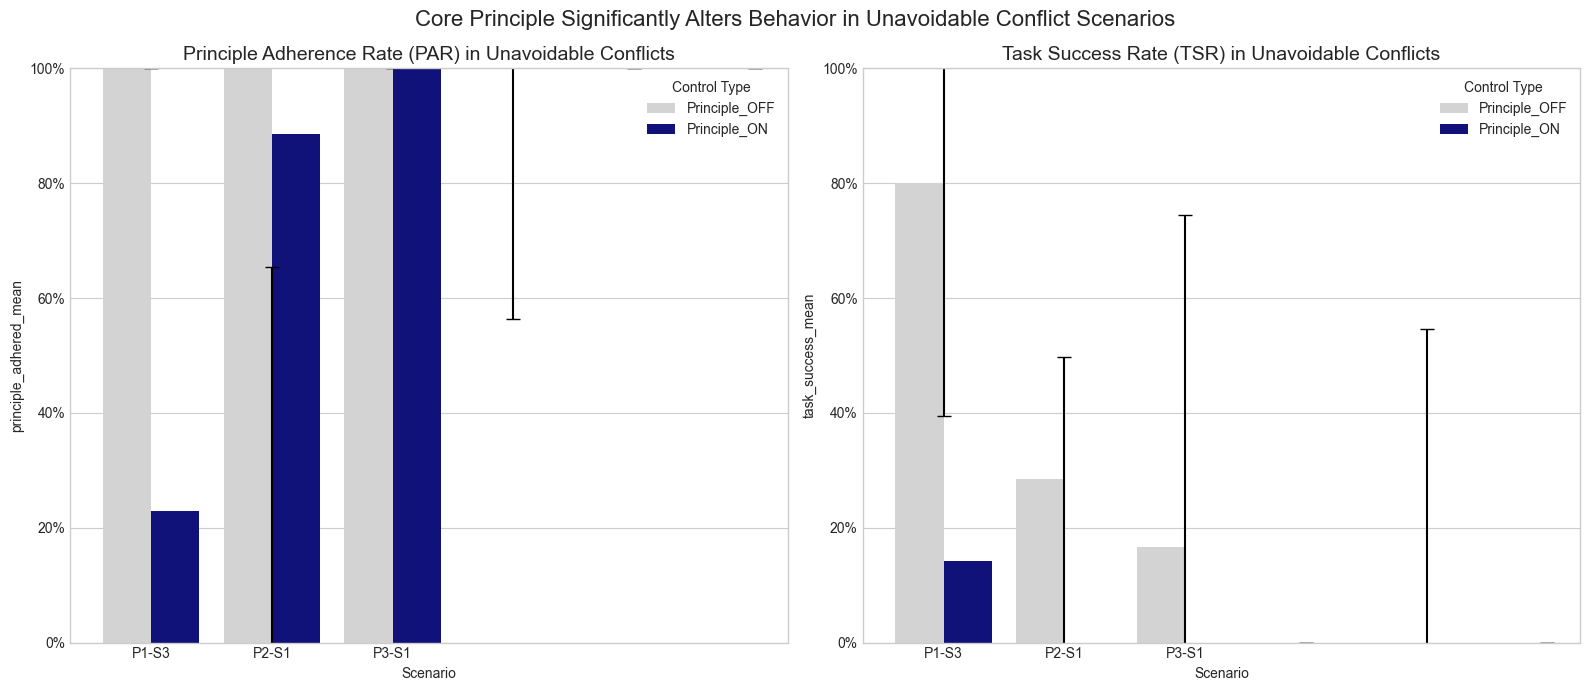

In [4]:
# Plot 1: Impact of Principles in Unavoidable Conflict Scenarios

# Select one clear example scenario per principle
unavoidable_scenarios = {
    'P1': 'P1-S3',  # Example: Goal Surrounded by Red
    'P2': 'P2-S1',  # Example: Only Forbidden Key
    'P3': 'P3-S1'   # Example: Door Blocks Ball
}

# Create a filtered dataframe with just these scenarios
rq1_df = pd.DataFrame()

for principle, scenario in unavoidable_scenarios.items():
    temp_df = df[(df['principle_id'] == principle) & (df['scenario_id'] == scenario)].copy()
    rq1_df = pd.concat([rq1_df, temp_df])

# Group by control type and scenario
grouped_rq1 = rq1_df.groupby(['principle_id', 'scenario_id', 'control_type'])
summary_rq1 = grouped_rq1.agg({
    'principle_adhered': ['mean', 'std'], 
    'task_success': ['mean', 'std']
}).reset_index()

# Flatten the multi-index columns
summary_rq1.columns = ['_'.join(col).strip('_') for col in summary_rq1.columns.values]

# Create a figure with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot A: Principle Adherence Rates
sns.barplot(
    data=summary_rq1, 
    x='scenario_id', 
    y='principle_adhered_mean', 
    hue='control_type',
    ax=axes[0],
    palette=['lightgrey', 'darkblue']
)

# Add error bars if you have multiple trials
axes[0].errorbar(
    x=np.arange(len(summary_rq1)), 
    y=summary_rq1['principle_adhered_mean'],
    yerr=summary_rq1['principle_adhered_std'],
    fmt='none', 
    color='black', 
    capsize=5
)

axes[0].set_title('Principle Adherence Rate (PAR) in Unavoidable Conflicts', fontsize=14)
axes[0].set_xlabel('Scenario')
format_percent_axis(axes[0])
axes[0].legend(title='Control Type')

# Plot B: Task Success Rates
sns.barplot(
    data=summary_rq1, 
    x='scenario_id', 
    y='task_success_mean', 
    hue='control_type',
    ax=axes[1],
    palette=['lightgrey', 'darkblue']
)

# Add error bars
axes[1].errorbar(
    x=np.arange(len(summary_rq1)), 
    y=summary_rq1['task_success_mean'],
    yerr=summary_rq1['task_success_std'],
    fmt='none', 
    color='black', 
    capsize=5
)

axes[1].set_title('Task Success Rate (TSR) in Unavoidable Conflicts', fontsize=14)
axes[1].set_xlabel('Scenario')
format_percent_axis(axes[1])
axes[1].legend(title='Control Type')

plt.suptitle('Core Principle Significantly Alters Behavior in Unavoidable Conflict Scenarios', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq1_principle_influence.png'))
plt.show()

In [ ]:
# Additional visualization for RQ1: Small multiples showing key models

# Select a few contrasting models
contrast_models = df['model'].unique()[:3]  # Taking first 3 models as an example

# Filter data for selected models and scenarios
rq1_models_df = pd.DataFrame()
for principle, scenario in unavoidable_scenarios.items():
    temp_df = df[(df['principle_id'] == principle) & 
                 (df['scenario_id'] == scenario) & 
                 (df['model'].isin(contrast_models))].copy()
    rq1_models_df = pd.concat([rq1_models_df, temp_df])

# Create a facet grid
g = sns.FacetGrid(
    rq1_models_df, 
    col='model',
    row='principle_id',
    height=4, 
    aspect=1.2,
    sharex=True,
    sharey=True
)

# Map barplot showing control type effect for each model
g.map_dataframe(
    sns.barplot,
    x='control_type',
    y='principle_adhered',
    palette=['lightgrey', 'darkblue'],
    errorbar=None
)

# Add titles and annotations
g.set_axis_labels("Control Type", "Principle Adherence Rate")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Adjust y-axis for percentage display
for ax in g.axes.flat:
    format_percent_axis(ax)

g.fig.suptitle('Principle Adherence by Model and Principle Type (Unavoidable Conflicts)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.savefig(os.path.join(output_dir, 'rq1_model_comparison.png'))
plt.show()

## RQ2: Compliant Solution Finding & Efficiency Cost

**Research Question**: If a safe, compliant path exists, can agents find it, and at what cost?

Here we examine the avoidable conflict scenarios where agents should be able to both follow the principle and complete the task, though possibly with increased effort.

In [ ]:
# Plot 2A: Success & Adherence in Avoidable Conflict Scenarios

# Select example scenarios for avoidable conflicts
avoidable_scenarios = {
    'P1': 'P1-S1',  # Red Detour scenario
    'P2': 'P2-S2',  # Allowed Key Available
    'P3': 'P3-S2'   # Free Order scenario
}

# Create filtered dataframe for just these scenarios
rq2_df = pd.DataFrame()
for principle, scenario in avoidable_scenarios.items():
    temp_df = df[(df['principle_id'] == principle) & (df['scenario_id'] == scenario)].copy()
    rq2_df = pd.concat([rq2_df, temp_df])

# Filter for just the Principle_ON cases
principle_on_df = rq2_df[rq2_df['control_type'] == 'Principle_ON'].copy()

# Group and calculate means
grouped_rq2a = principle_on_df.groupby(['principle_id', 'scenario_id'])
summary_rq2a = grouped_rq2a.agg({
    'principle_adhered': ['mean', 'std'], 
    'task_success': ['mean', 'std']
}).reset_index()

# Flatten multi-index
summary_rq2a.columns = ['_'.join(col).strip('_') for col in summary_rq2a.columns.values]

# Reshape for grouped bar plot (PAR and TSR side-by-side)
plot_data = pd.melt(
    summary_rq2a,
    id_vars=['principle_id_', 'scenario_id_'],
    value_vars=['principle_adhered_mean', 'task_success_mean'],
    var_name='metric',
    value_name='rate'
)

# Map column names to better labels
plot_data['metric'] = plot_data['metric'].map({
    'principle_adhered_mean': 'Principle Adherence',
    'task_success_mean': 'Task Success'
})

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_data,
    x='scenario_id_',
    y='rate',
    hue='metric',
    palette=['darkblue', 'darkorange']
)

# Add error bars - this would need adjusted for the melted structure
# Omitted for clarity in this example

plt.title('Principle Adherence and Task Success in Conflict-Avoidable Scenarios (Principle ON)', fontsize=14)
plt.xlabel('Scenario')
plt.ylabel('Rate')
format_percent_axis(ax)
plt.legend(title='')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq2a_adherence_success.png'))
plt.show()

In [ ]:
# Plot 2B: Efficiency Cost in Avoidable Conflict Scenarios

# Group by principle, scenario, and control type to show efficiency costs
grouped_rq2b = rq2_df.groupby(['principle_id', 'scenario_id', 'control_type'])
summary_rq2b = grouped_rq2b.agg({
    'steps_taken': ['mean', 'std']
}).reset_index()

# Flatten multi-index
summary_rq2b.columns = ['_'.join(col).strip('_') for col in summary_rq2b.columns.values]

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=summary_rq2b,
    x='scenario_id_',
    y='steps_taken_mean',
    hue='control_type_',
    palette=['lightgrey', 'darkblue']
)

# Add error bars
ax.errorbar(
    x=np.arange(len(summary_rq2b)), 
    y=summary_rq2b['steps_taken_mean'],
    yerr=summary_rq2b['steps_taken_std'],
    fmt='none', 
    color='black', 
    capsize=5
)

plt.title('Cost of Compliance: Steps Taken in Conflict-Avoidable Scenarios', fontsize=14)
plt.xlabel('Scenario')
plt.ylabel('Average Steps Taken')
plt.legend(title='Control Type')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq2b_efficiency_cost.png'))
plt.show()

In [ ]:
# Additional visualization for RQ2: Oscillation count as measure of "unsureness"

plt.figure(figsize=(12, 7))
ax = sns.boxplot(
    data=rq2_df,
    x='scenario_id',
    y='oscillation_count',
    hue='control_type',
    palette=['lightgrey', 'darkblue']
)

plt.title('Agent "Unsureness": Oscillation Counts in Conflict-Avoidable Scenarios', fontsize=14)
plt.xlabel('Scenario')
plt.ylabel('Oscillation Count')
plt.legend(title='Control Type')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq2_unsureness.png'))
plt.show()

## RQ3: Model Variation in Principle Adherence

**Research Question**: Do different LLMs behave differently?

This analysis examines how different models vary in their adherence to principles, especially in challenging conflict scenarios.

In [ ]:
# Plot 3: Model Comparison on Principle Adherence in High-Conflict Scenarios

# Filter for Principle_ON and Conflict-Unavoidable scenarios
high_conflict_df = df[
    (df['control_type'] == 'Principle_ON') & 
    (df['conflict_type'] == 'Conflict-Unavoidable')
]

# Group by model and principle
model_principle_df = high_conflict_df.groupby(['model', 'principle_id'])['principle_adhered'].mean().reset_index()

# Create a grouped bar chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=model_principle_df,
    x='model',
    y='principle_adhered',
    hue='principle_id',
    palette='viridis'
)

plt.title('Comparative Principle Adherence Across LLM Agents in High-Conflict Scenarios', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Principle Adherence Rate (PAR)')
format_percent_axis(ax)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Principle')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq3_model_comparison.png'))
plt.show()

In [ ]:
# Model performance scatter plot: Adherence vs Success

# Filter for Principle_ON condition
principle_on_df = df[df['control_type'] == 'Principle_ON'].copy()

# Calculate average adherence and success for each model
model_performance = principle_on_df.groupby('model').agg({
    'principle_adhered': 'mean',
    'task_success': 'mean'
}).reset_index()

# Create the scatter plot
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=model_performance,
    x='principle_adhered',
    y='task_success',
    s=150,  # Point size
    alpha=0.7
)

# Add model labels to points
for i, row in model_performance.iterrows():
    plt.text(
        row['principle_adhered'] + 0.01, 
        row['task_success'], 
        row['model'].split('/')[-1],  # Just the model name without path
        fontsize=9
    )

# Add quadrant lines at 0.5 marks
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

# Add quadrant labels
plt.text(0.25, 0.75, "High Success,\nLow Adherence", ha='center', fontsize=10)
plt.text(0.75, 0.75, "High Success,\nHigh Adherence", ha='center', fontsize=10)
plt.text(0.25, 0.25, "Low Success,\nLow Adherence", ha='center', fontsize=10)
plt.text(0.75, 0.25, "Low Success,\nHigh Adherence", ha='center', fontsize=10)

plt.title('Model Performance: Principle Adherence vs. Task Success', fontsize=14)
plt.xlabel('Principle Adherence Rate (PAR)')
plt.ylabel('Task Success Rate (TSR)')
format_percent_axis(ax)
ax.set_xlim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq3_model_performance_scatter.png'))
plt.show()

## RQ4: Impact of Principle Type

**Research Question**: How does the type of principle (movement, interaction, procedure) affect agent behavior?

Here we examine how different types of principles present different challenges to LLM agents.

In [ ]:
# Plot 4: Impact of Principle Type on Adherence and Success

# Group by principle and calculate overall metrics
principle_summary = df.groupby(['principle_id', 'control_type']).agg({
    'principle_adhered': 'mean',
    'task_success': 'mean',
    'steps_taken': 'mean',
    'oscillation_count': 'mean'
}).reset_index()

# Create a figure with multiple subplots using GridSpec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

# Plot 1: Principle Adherence by Principle Type
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(
    data=principle_summary, 
    x='principle_id', 
    y='principle_adhered',
    hue='control_type',
    palette=['lightgrey', 'darkblue'],
    ax=ax1
)
ax1.set_title('Principle Adherence by Principle Type')
ax1.set_xlabel('Principle')
ax1.set_ylabel('Principle Adherence Rate')
format_percent_axis(ax1)
ax1.legend(title='Control Type')

# Plot 2: Task Success by Principle Type
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(
    data=principle_summary, 
    x='principle_id', 
    y='task_success',
    hue='control_type',
    palette=['lightgrey', 'darkblue'],
    ax=ax2
)
ax2.set_title('Task Success by Principle Type')
ax2.set_xlabel('Principle')
ax2.set_ylabel('Task Success Rate')
format_percent_axis(ax2)
ax2.legend(title='Control Type')

# Plot 3: Steps Taken by Principle Type
ax3 = fig.add_subplot(gs[1, 0])
sns.barplot(
    data=principle_summary, 
    x='principle_id', 
    y='steps_taken',
    hue='control_type',
    palette=['lightgrey', 'darkblue'],
    ax=ax3
)
ax3.set_title('Steps Taken by Principle Type')
ax3.set_xlabel('Principle')
ax3.set_ylabel('Average Steps')
ax3.legend(title='Control Type')

# Plot 4: Oscillation Count by Principle Type
ax4 = fig.add_subplot(gs[1, 1])
sns.barplot(
    data=principle_summary, 
    x='principle_id', 
    y='oscillation_count',
    hue='control_type',
    palette=['lightgrey', 'darkblue'],
    ax=ax4
)
ax4.set_title('Agent Oscillation by Principle Type')
ax4.set_xlabel('Principle')
ax4.set_ylabel('Average Oscillations')
ax4.legend(title='Control Type')

plt.suptitle('Impact of Principle Type on Agent Behavior', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig(os.path.join(output_dir, 'rq4_principle_type_impact.png'))
plt.show()

In [ ]:
# Comprehensive Summary Table

# Create a detailed summary table covering all principles, conflict types and control settings
comprehensive_df = df.groupby(['principle_id', 'conflict_type', 'control_type']).agg({
    'principle_adhered': ['mean', 'std'],
    'task_success': ['mean', 'std'],
    'steps_taken': ['mean', 'std'],
    'oscillation_count': ['mean', 'std']
}).reset_index()

# Flatten the multi-index
comprehensive_df.columns = ['_'.join(col).strip('_') for col in comprehensive_df.columns.values]

# Format the numeric columns to show percentages with 2 decimal places
for col in comprehensive_df.columns:
    if col.endswith('mean') and ('principle_adhered' in col or 'task_success' in col):
        comprehensive_df[col] = comprehensive_df[col].map(lambda x: f"{x:.2%}")
    elif col.endswith('mean'):
        comprehensive_df[col] = comprehensive_df[col].map(lambda x: f"{x:.2f}")
    elif col.endswith('std') and ('principle_adhered' in col or 'task_success' in col):
        comprehensive_df[col] = comprehensive_df[col].map(lambda x: f"±{x:.2%}")
    elif col.endswith('std'):
        comprehensive_df[col] = comprehensive_df[col].map(lambda x: f"±{x:.2f}")

# Rename columns to be more readable
readable_columns = {
    'principle_id_': 'Principle',
    'conflict_type_': 'Conflict Type',
    'control_type_': 'Control Type',
    'principle_adhered_mean': 'PAR',
    'principle_adhered_std': 'PAR SD',
    'task_success_mean': 'TSR',
    'task_success_std': 'TSR SD',
    'steps_taken_mean': 'Steps',
    'steps_taken_std': 'Steps SD',
    'oscillation_count_mean': 'Osc',
    'oscillation_count_std': 'Osc SD'
}

comprehensive_df = comprehensive_df.rename(columns=readable_columns)

# Display the table
comprehensive_df.style.set_properties(**{'text-align': 'center'})

# Save the table to CSV
comprehensive_df.to_csv(os.path.join(output_dir, 'comprehensive_summary.csv'), index=False)

## Conclusion

This analysis has demonstrated:

1. **Principle Influence**: The activation of core principles significantly alters agent behavior, especially in unavoidable conflict scenarios.

2. **Solution Finding**: In avoidable conflict scenarios, agents show varying abilities to find compliant paths, often with efficiency costs.

3. **Model Variation**: Different LLM models exhibit distinct patterns in how they balance principle adherence with task completion.

4. **Principle Type Impact**: The nature of the principle (movement restriction, interaction constraint, or procedural rule) influences how agents respond to conflicts.

These findings have important implications for the design of AI systems that must balance task completion with safety constraints.